# EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# El archivo se encuentra en el bucket
df=pd.read_csv('gs://mit-proyect-data/Base.csv') 
df.head(3)

_request non-retriable exception: Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object. Permission 'storage.objects.get' denied on resource (or it may not exist)., 401
Traceback (most recent call last):
  File "/home/leonel-unix/workspace/MIT-project-banking/.venv/lib/python3.12/site-packages/gcsfs/retry.py", line 135, in retry_request
    return await func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leonel-unix/workspace/MIT-project-banking/.venv/lib/python3.12/site-packages/gcsfs/core.py", line 476, in _request
    validate_response(status, contents, path, args)
  File "/home/leonel-unix/workspace/MIT-project-banking/.venv/lib/python3.12/site-packages/gcsfs/retry.py", line 122, in validate_response
    raise HttpError(error)
gcsfs.retry.HttpError: Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object. Permission 'storage.objects.get' denied on resource (or it may not exist)., 401


HttpError: Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object. Permission 'storage.objects.get' denied on resource (or it may not exist)., 401

In [ ]:
# print('Tamaño de data:', df.shape)
print('--------------------------')
print('Tipos de variables del dataframe:')
print(df.dtypes.value_counts())
print('--------------------------')
print('Variables con datos vacios "null"')
nulos = df.isnull().sum().sort_values(ascending=False)
print(nulos[nulos>0].count())
print('--------------------------')
df.info()

--------------------------
Tipos de variables del dataframe:
int64      18
float64     9
object      5
Name: count, dtype: int64
--------------------------
Variables con datos vacios "null"
0
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type  

 - Device_fraud_count solo tiene valores 0, **se descarta**
 - La variable month **se descarta** porque soolo tiene valores del [0,7], por lo que no se puede inferir por temporalidad o meses restantes que el modelo no conozca.
 - Los valores faltantes estan representados con -1, las variables con valores faltantes son:
    - prev_address_months_count
    - current_address_months_count
    - intended_balcon_amount
    - bank_months_count
    - session_length_in_minutes
 - Variables categoricas:
    - payment_type
    - employment_status
    - housing_status
    - source
    - device_os

In [ ]:
var_nan = ['prev_address_months_count','current_address_months_count','intended_balcon_amount',
           'bank_months_count','session_length_in_minutes','device_distinct_emails_8w']
var_cat = ['payment_type','employment_status','housing_status','source','device_os']
target = ['fraud_bool']

df[var_nan] = df[var_nan].replace(-1, np.nan).astype('float')
df = df.drop(columns = ['device_fraud_count','month'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 30 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         287080 non-null   float64
 4   current_address_months_count      995746 non-null   float64
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [ ]:
df['name_email_similarity']

La columna **prev_address_months_count** tiene 72% de vacios, se eliminara y se creara en su lugar columna prev_address_valid: 0-> no valido, 1-> valido

In [22]:
df['prev_address_valid'] = np.where(df['prev_address_months_count'] > 0,1,0)
df = df.drop(columns = ['prev_address_months_count'])
df.head(3)

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,prev_address_valid
0,0,0.3,0.986506,25.0,40,0.006735,102.453711,AA,1059,13096.035018,...,9.0,0,1500.0,0,INTERNET,16.224843,linux,1,1.0,0
1,0,0.8,0.617426,89.0,20,0.010095,-0.849551,AD,1658,9223.283431,...,2.0,0,1500.0,0,INTERNET,3.363854,other,1,1.0,0
2,0,0.8,0.996707,14.0,40,0.012316,-1.490386,AB,1095,4471.472149,...,30.0,0,200.0,0,INTERNET,22.730559,windows,0,1.0,1


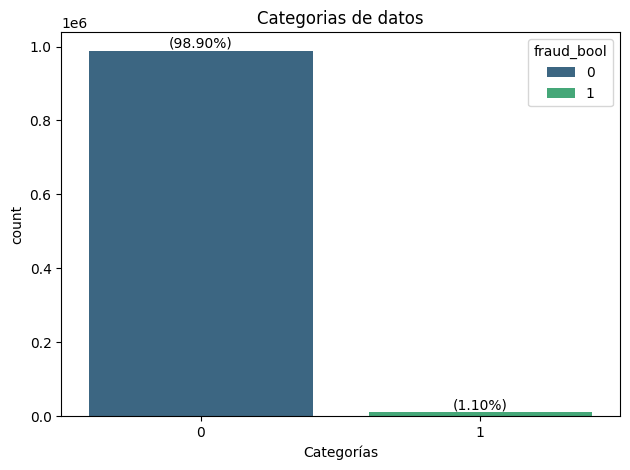

In [13]:
# Categoria Datos
fraud_bool_counts = df[target].value_counts().reset_index()
fraud_bool_counts['pct'] = fraud_bool_counts['count'] / fraud_bool_counts['count'].sum() * 100

# Crear el gráfico de barras con Seaborn
ax = sns.barplot(
                 data=fraud_bool_counts,
                 x='fraud_bool', y='count',
                 hue='fraud_bool', 
                 palette="viridis",legend=True
                )

plt.title("Categorias de datos")
plt.xlabel("Categorías")
plt.xticks(rotation=0)

# Añadir el conteo y el porcentaje a cada barra
for i, (count, percentage) in enumerate(zip(fraud_bool_counts['count'], fraud_bool_counts['pct'])):
    ax.text(i, count + 30, f'({percentage:.2f}%)', ha='center', va='bottom', fontsize=10)

plt.tight_layout() # Para ajustar el diseño y evitar que las etiquetas se corten
plt.show()

## Distribucion de la variable **Target: fraud_bool**

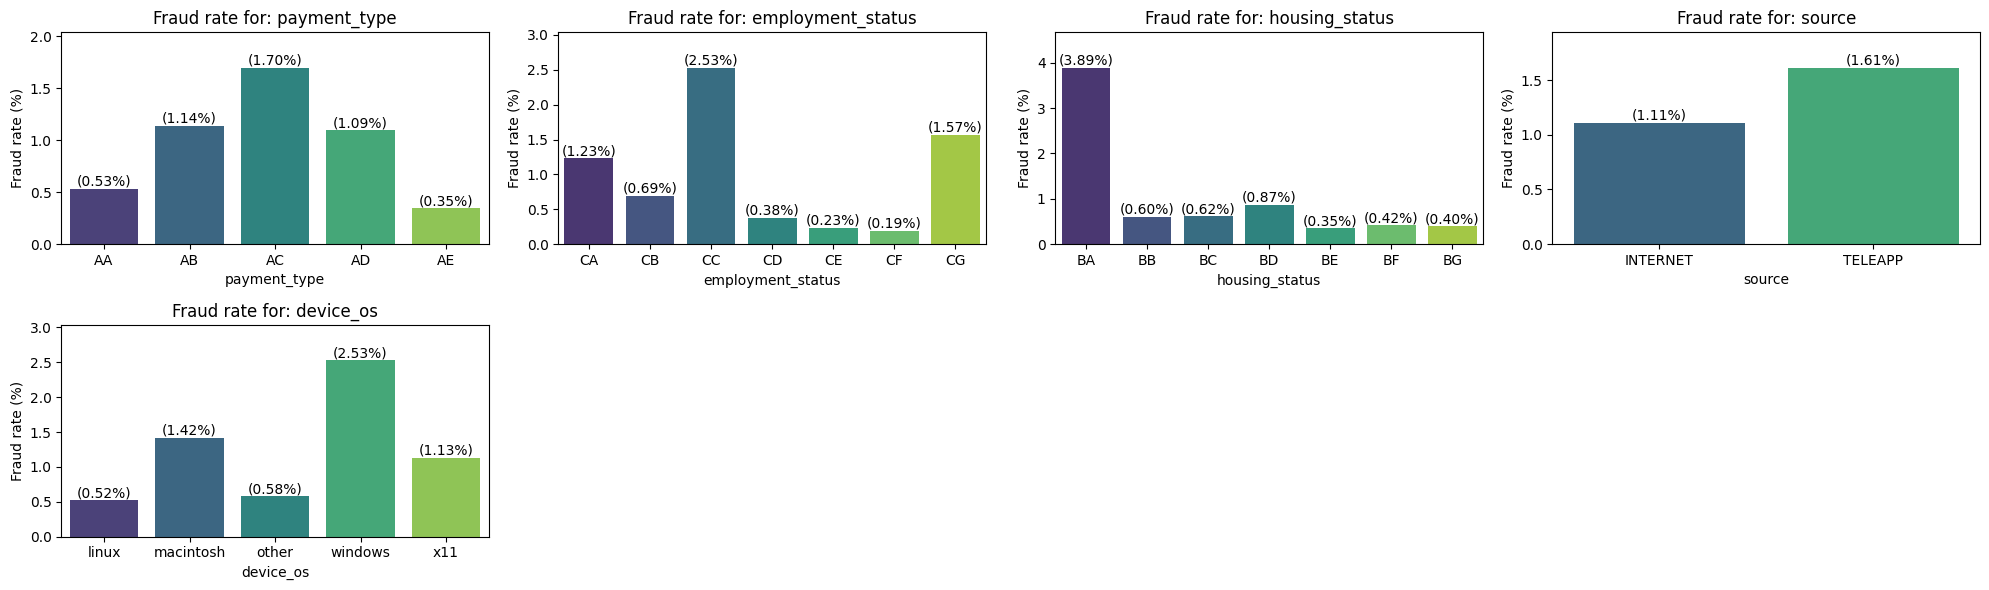

In [35]:
# Grafico variables categoricas

# Plot
n_cols = 4
n_vars = len(var_cat)
n_rows = math.ceil(n_vars / n_cols)

# Tamaño ajustado de figura
plt.figure(figsize=(n_cols * 5, n_rows * 3))

for i, col in enumerate(df[var_cat].columns, 1):
    fraud_counts = (
                    df.groupby(col)[target]
                      .value_counts()
                      .unstack(fill_value=0)
                      .reset_index()
                      .rename(columns={0: f'{target}_0', 1: f'{target}_1'})
                      .rename_axis(columns=None)
                    )
    fraud_counts['fraud_bool_0_pct'] = fraud_counts[f'{target}_0']/len(df[col])*100
    fraud_counts['fraud_bool_1_pct'] = fraud_counts[f'{target}_1']/len(df[col])*100
    fraud_counts['fraud_rate'] = fraud_counts[f'{target}_1']/fraud_counts[f'{target}_0']*100
    # display(fraud_counts)
    
    plt.subplot(n_rows, n_cols, i)
    
    ax = sns.barplot(data=fraud_counts,x=col,y='fraud_rate',hue=col,palette="viridis")
    ax.set_ylim(0, fraud_counts['fraud_rate'].max() *1.2)
    
    for i, percentage in enumerate(fraud_counts['fraud_rate']):
        ax.text(i, percentage , f'({percentage:.2f}%)', ha='center', va='bottom', fontsize=10)
        
    plt.ylabel('Fraud rate (%)')
    plt.title(f'Fraud rate for: {col}')
    
plt.tight_layout() # Para ajustar el diseño y evitar que las etiquetas se corten 
plt.show()

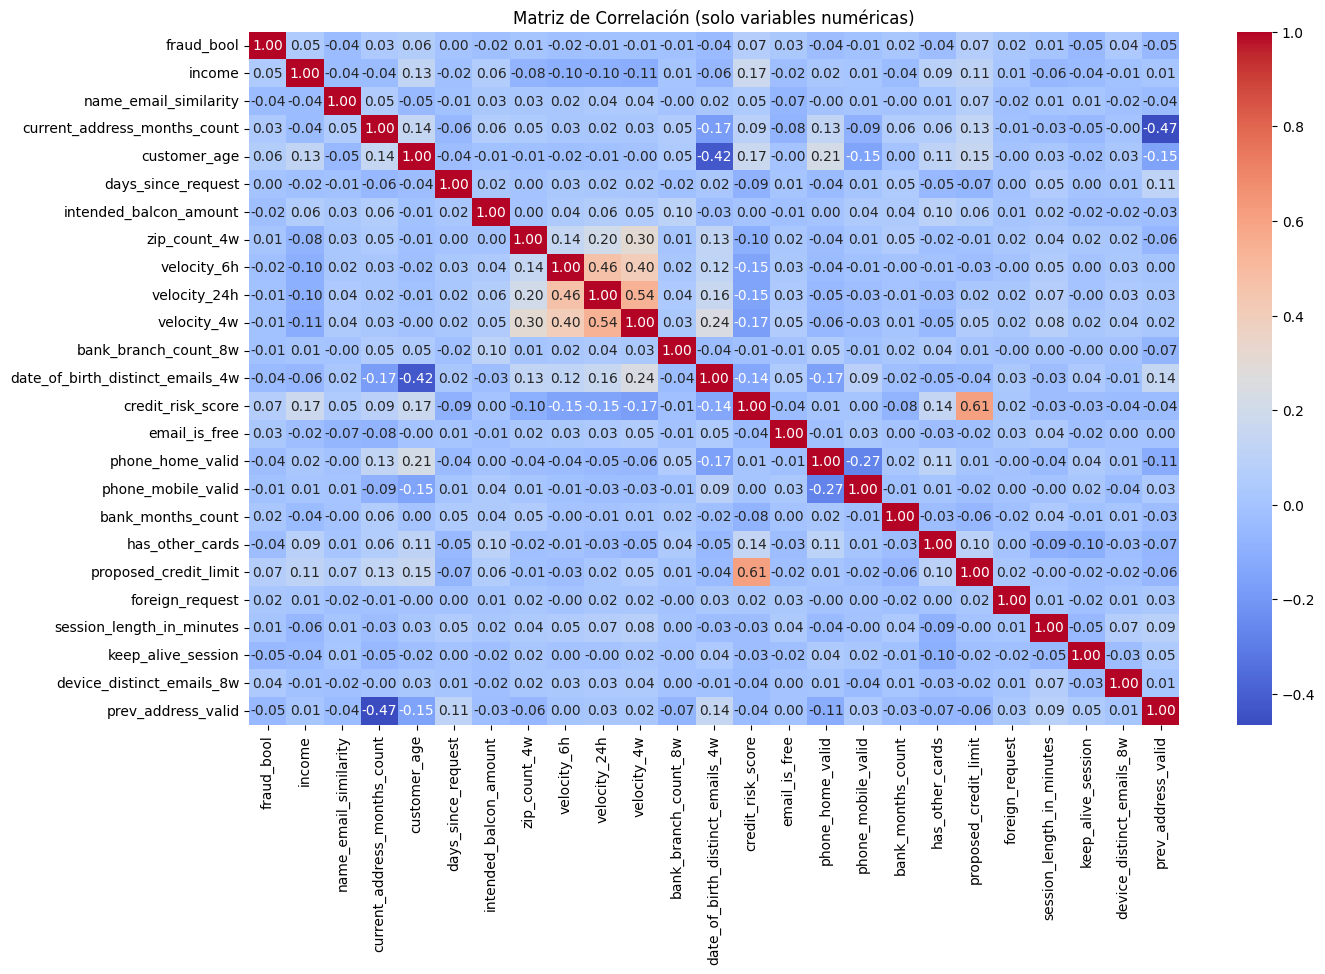

In [36]:
df_num = df.select_dtypes(include=['number'])

corr_matrix = df_num.corr()

plt.figure(figsize=(15, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación (solo variables numéricas)")
plt.show()

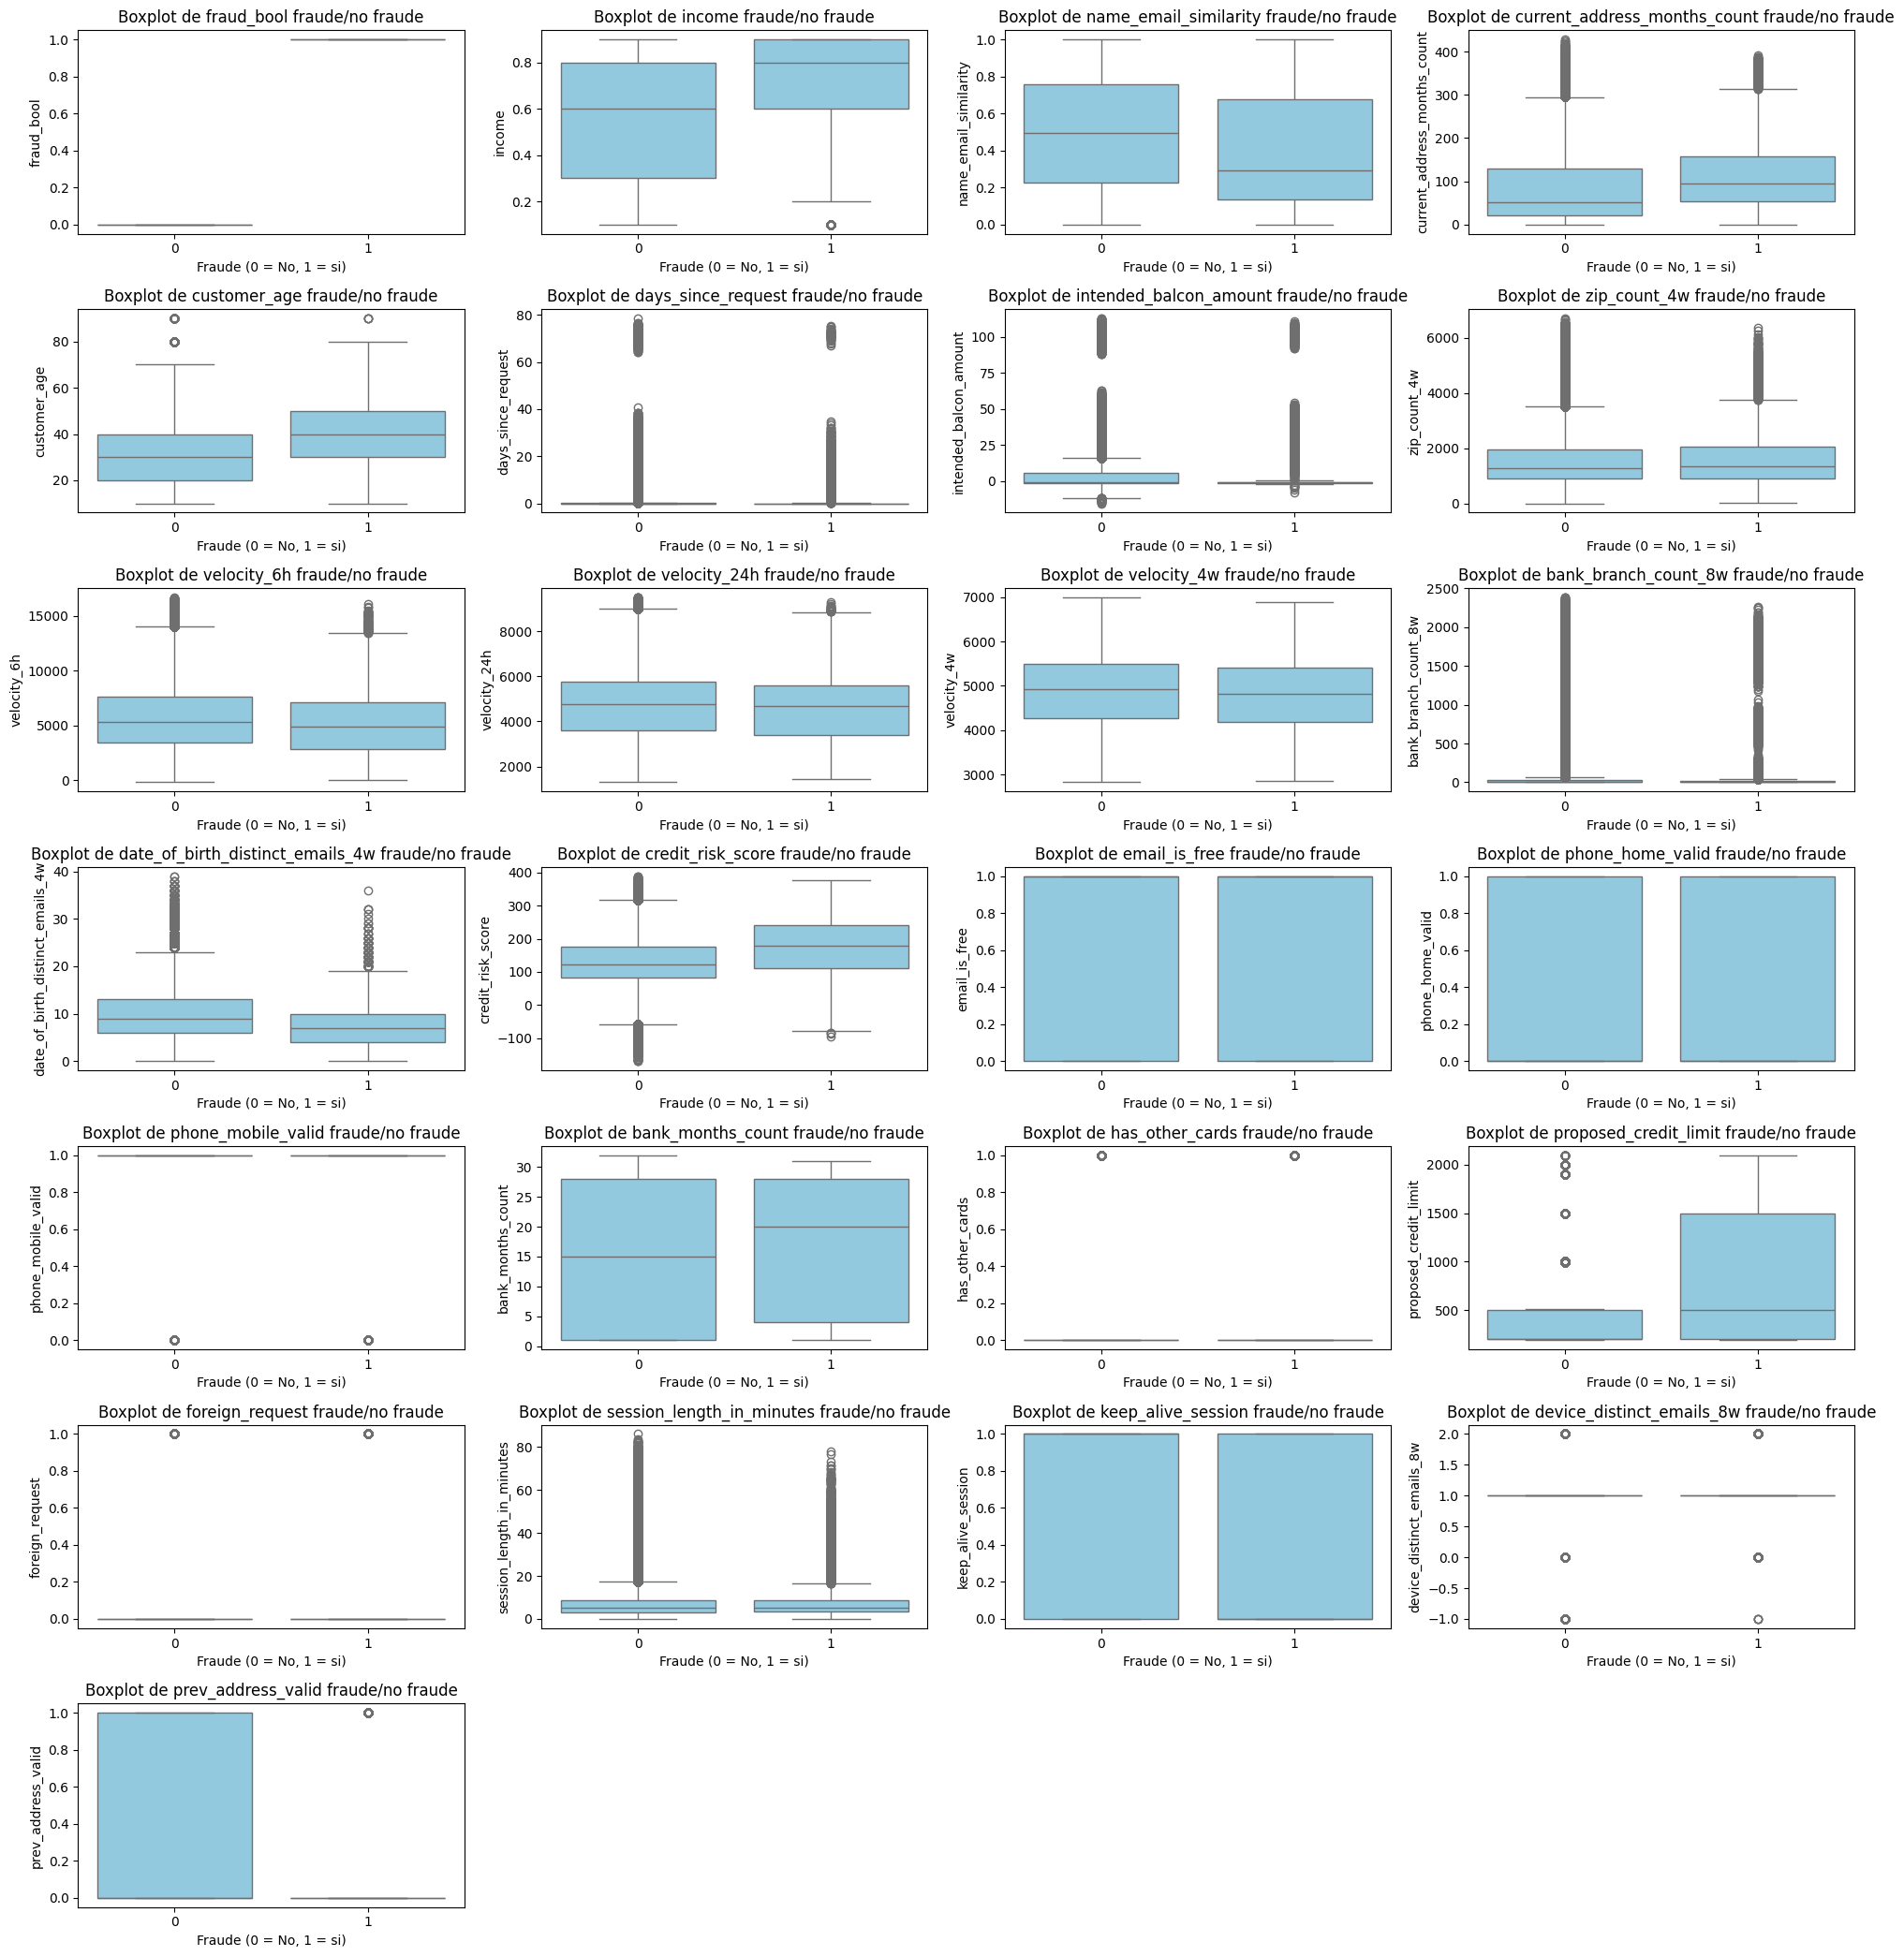

In [38]:
# Boxplot de variables numericas
df_num = df.select_dtypes(include='number')

n_cols = 4
n_vars = len(df_num.columns)
n_rows = math.ceil(n_vars / n_cols)

# Tamaño ajustado de figura
plt.figure(figsize=(n_cols * 5, n_rows * 3))

# Crear boxplots en múltiples columnas
for i, col in enumerate(df_num.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x="fraud_bool", y=col, data=df, color='skyblue')
    plt.title(f"Boxplot de {col} fraude/no fraude")
    plt.xlabel("Fraude (0 = No, 1 = si)")
    plt.ylabel(col)
    plt.tight_layout()

plt.show()

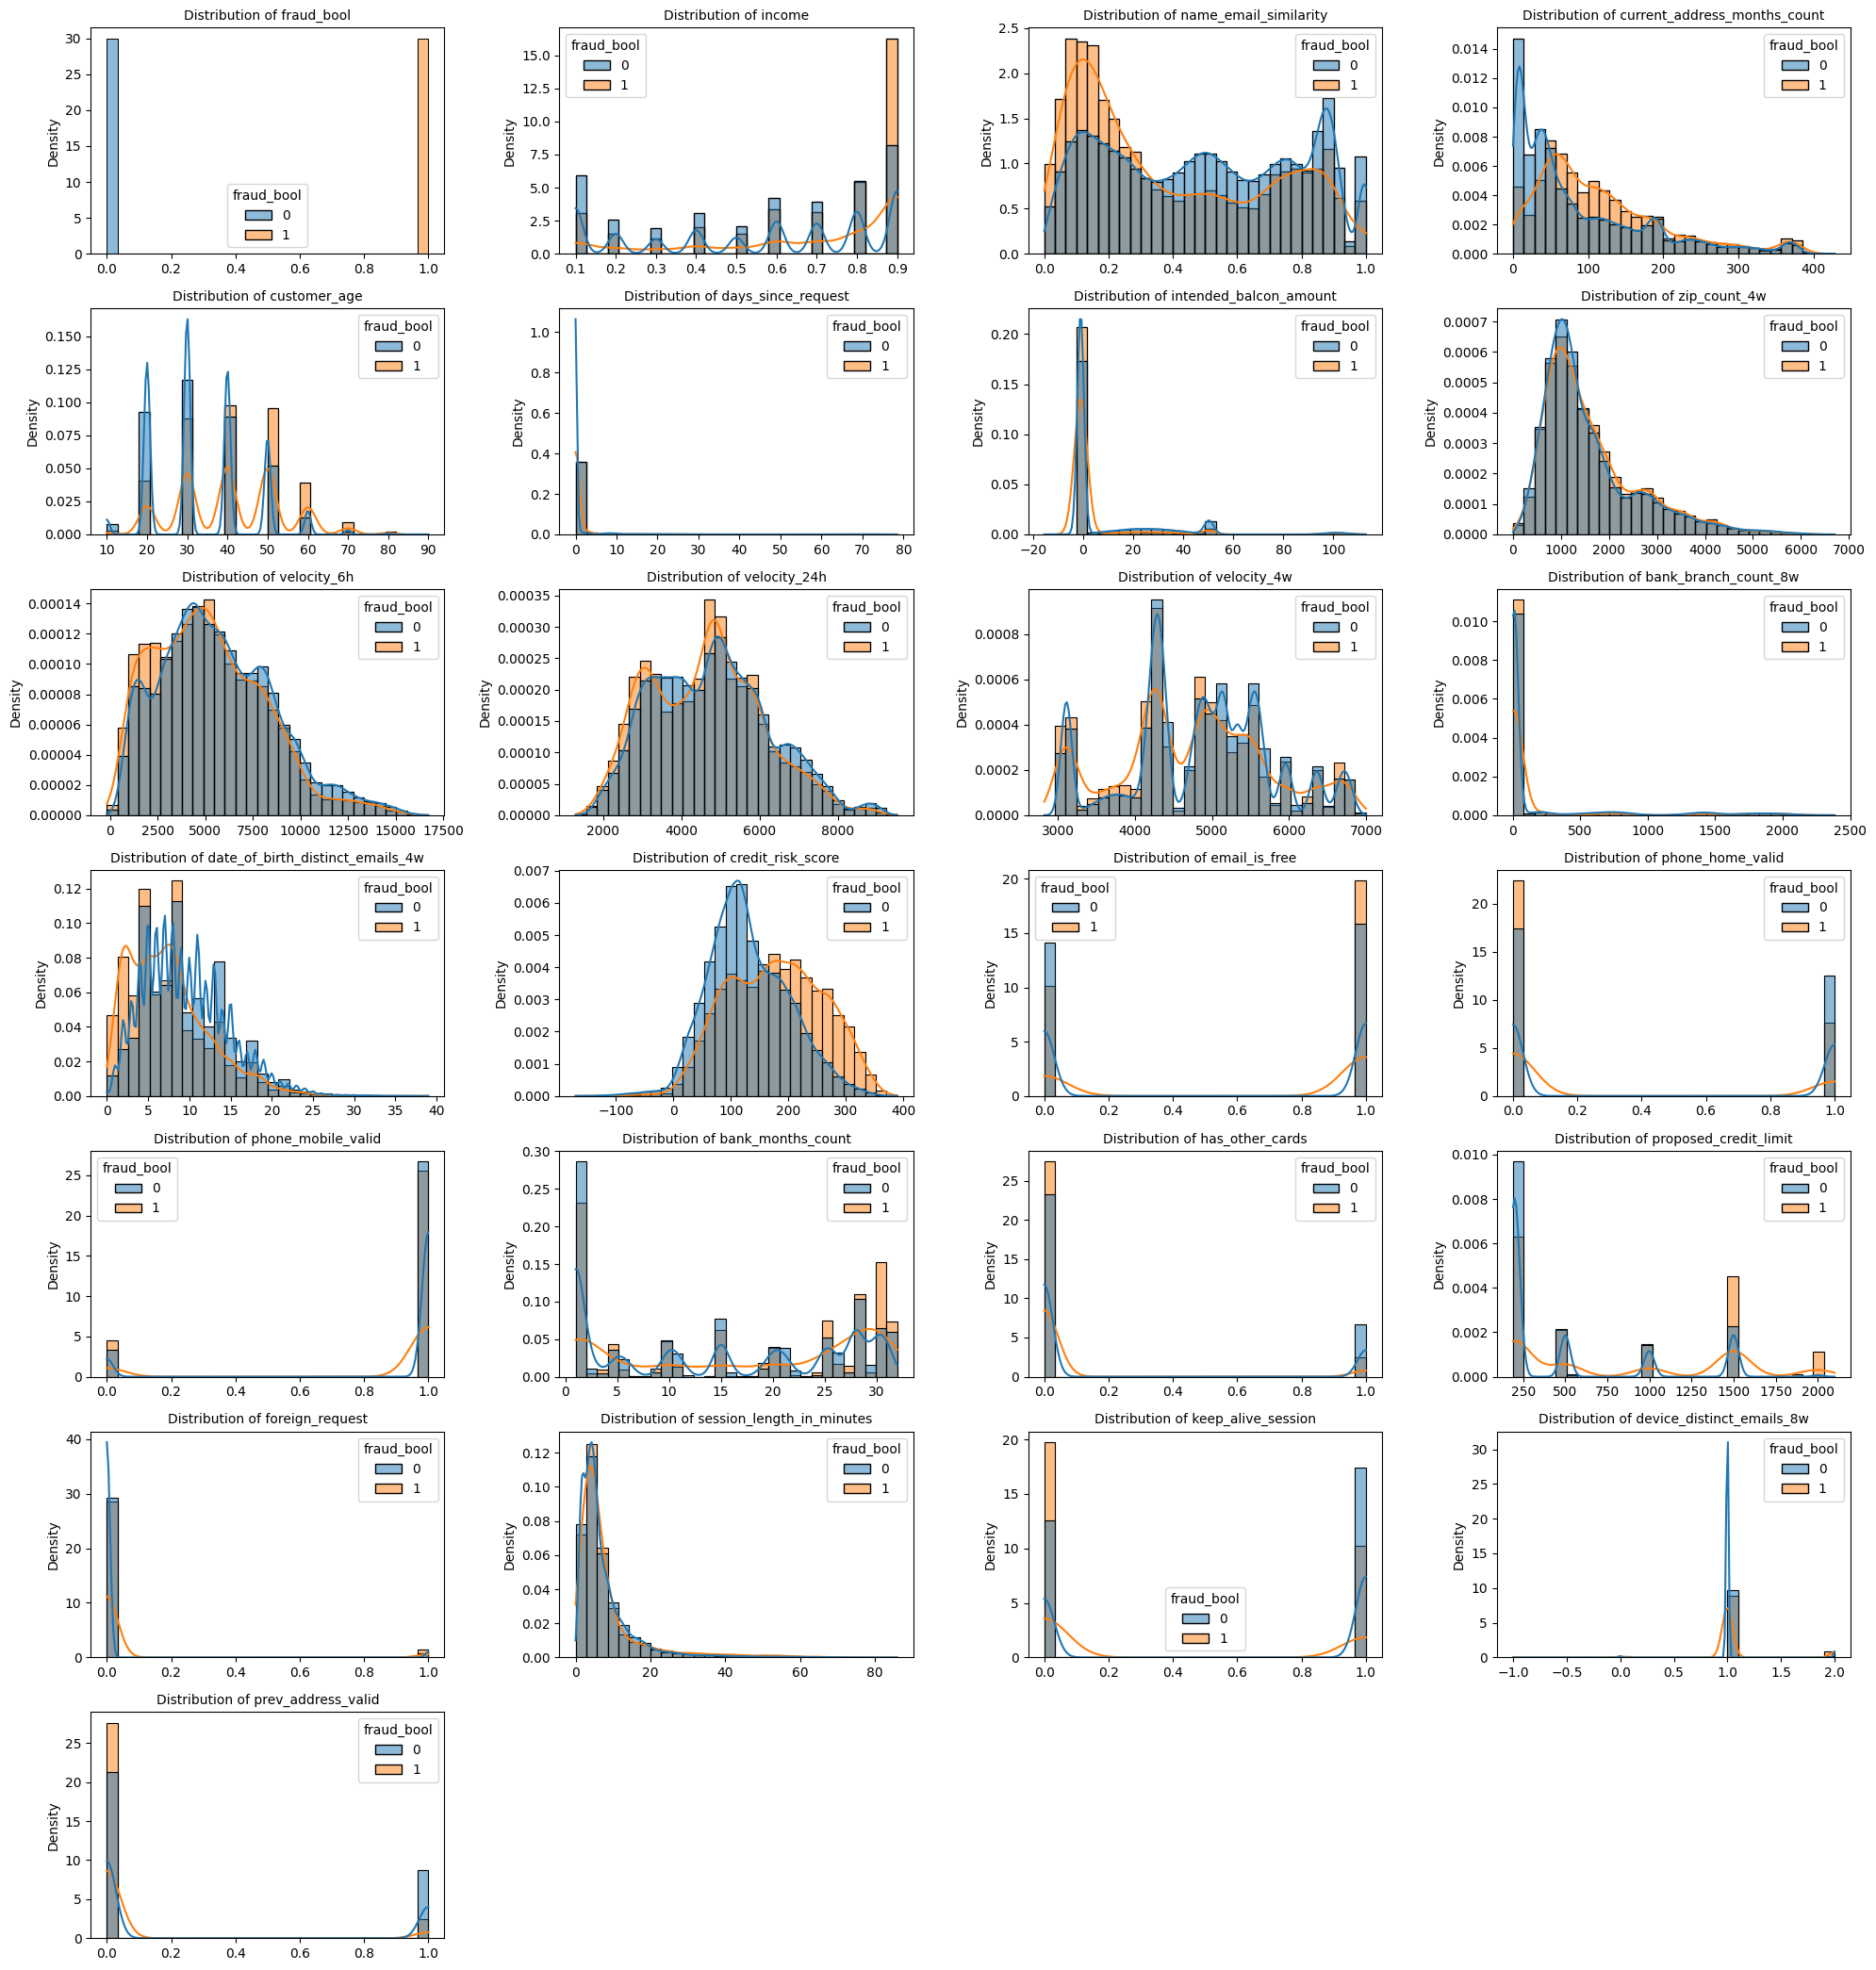

In [40]:
# Grafico de distirbuciones

n_cols = 4
n_vars = len(df_num.columns)
n_rows = math.ceil(n_vars / n_cols)

# Tamaño ajustado de figura
plt.figure(figsize=(n_cols * 5, n_rows * 3))

for i, col in enumerate(df_num.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Solo activar kde si la variable tiene más de 1 valor distinto
    if df_num[col].nunique() > 1:
        sns.histplot(data=df, x=col, hue="fraud_bool",
                     kde=True, stat="density",
                     common_norm=False, bins=30, alpha=0.5)
    else:
        sns.histplot(data=df, x=col, hue="fraud_bool",
                     kde=False, stat="count",
                     bins=1, alpha=0.5)
    
    plt.title(f'Distribution of {col}', fontsize=10)
    plt.xlabel('')
    plt.ylabel('Density')
    plt.tight_layout()

plt.show()

In [ ]:
display(df[df['intended_balcon_amount'] == -1 ]['intended_balcon_amount'].shape)
# df['intended_balcon_amount'].describe()
# df['intended_balcon_amount'].value_counts()

In [25]:
df['days_since_request'].describe()

count    1.000000e+06
mean     1.025705e+00
std      5.381835e+00
min      4.036860e-09
25%      7.193246e-03
50%      1.517574e-02
75%      2.633069e-02
max      7.845690e+01
Name: days_since_request, dtype: float64

<Axes: xlabel='log_bank_branch_count_8w', ylabel='Density'>

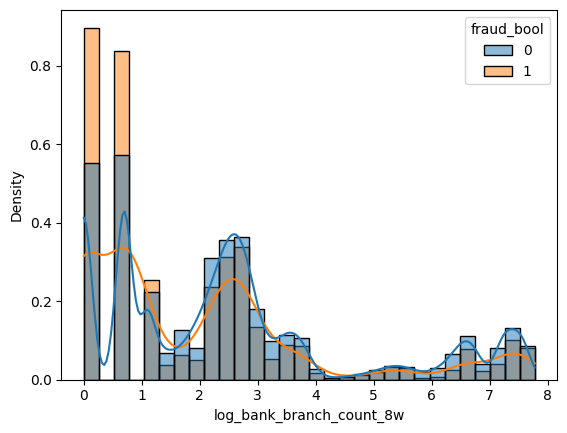

In [65]:
df["log_bank_branch_count_8w"] = np.log1p(df["bank_branch_count_8w"])
sns.histplot(data=df, x='log_bank_branch_count_8w', hue="fraud_bool",
                     kde=True, stat="density",
                     common_norm=False, bins=30, alpha=0.5)

La variable intended_balcon_amount tiene 70% valores <0 por tanto se identifica que el importe inicial transferido de la solicitud es negativo lo cual no tiene explicabilidad. **Se elimina**. \
Las variables velocity estan correlacionadas y se debe tratar el valor negativo presente. Ademas se creara ratios entre ventanas para capturar el comportamiento de volumen de transacciones.
 * ratio_velocity_6h_24H -> si es mayor a 1 indica que las ultimas 6h horas hubo mayor actividad promedio por hora que las ultimas 24h

La variable bank_branch_count_8w contiene outliers muy grandes, sin embargo puede aportar explicabilidad para sucursales con alto volumen de transacciones. Se usara log (1+x) para escalar los valores.\
La variable log_days_since_request contiene outliers muy grandes, se aplica log(1+x) para escalar los valores y tener explicabilidad en el modelo.\
La variable bank_months_count contiene 30% nan, se creara nueva variable prev_bank_months_count con valores 1 y 0, lo cual indica si el cliente tiene una cuenta anterior con el banco.\
Se elimina **source**, TELEAPP tiene muy pocos valores.\
Existen clientes con score bajo pero tienen alto ingreso se creara una variable income_risk_score, para determinar los ingresos altos y sospechosos\


In [5]:
df = df.drop(columns = ['intended_balcon_amount', 'source'])
df['velocity_6h'] = np.where(df['velocity_6h'] <= 0,df["velocity_6h"].quantile(0.25),df["velocity_6h"])
df['ratio_velocity_6h_24h'] = df['velocity_6h']/df['velocity_24h']
df['ratio_velocity_24h_4w'] = df['velocity_24h']/df['velocity_4w']
df['log_bank_branch_count_8w'] = np.log1p(df['bank_branch_count_8w'])
df['log_days_since_request'] = np.log1p(df['days_since_request'])
df['prev_bank_months_count'] = np.where(df['bank_months_count'] <=0, 0, 1)
df['income_risk_score'] = df['income']*df['credit_risk_score']
# Comparar normalizadas, y percentiles
# Crear yaml para configuracion de parametros


# Models

In [72]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [74]:
pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 58.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

cat_features = ['payment_type','employment_status','housing_status','device_os']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[cat_features])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat_features))
data_encoded = pd.concat([df.drop(columns=cat_features), encoded_df], axis=1)


In [10]:
#Sin balancear
X = data_encoded.drop(columns=['fraud_bool'])
y = data_encoded['fraud_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

neg, pos = y.value_counts()[0], y.value_counts()[1]
scale_pos_weight = neg / pos

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        # class_weight='balanced',
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        eval_metric='logloss',
        # scale_pos_weight=scale_pos_weight,
        random_state=42
    ),
    'LightGBM': lgb.LGBMClassifier(
        random_state=42,
        # scale_pos_weight=scale_pos_weight
    )
}
# logistico

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }
results

[LightGBM] [Info] Number of positive: 8920, number of negative: 791080
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3994
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011150 -> initscore=-4.485103
[LightGBM] [Info] Start training from score -4.485103


{'Random Forest': {'Accuracy': 0.98946,
  'Precision': 0.5555555555555556,
  'Recall': 0.002370791844476055,
  'F1 Score': 0.004721435316336166,
  'ROC AUC': 0.8352883886999025},
 'XGBoost': {'Accuracy': 0.989225,
  'Precision': 0.4017094017094017,
  'Recall': 0.044570886676149835,
  'F1 Score': 0.08023900981647461,
  'ROC AUC': 0.8859377134251474},
 'LightGBM': {'Accuracy': 0.98917,
  'Precision': 0.38910505836575876,
  'Recall': 0.0474158368895211,
  'F1 Score': 0.08453085376162299,
  'ROC AUC': 0.893704140987002}}

In [11]:
from sklearn.metrics import classification_report

best_model_name = max(results, key = lambda k: results[k]['ROC AUC'])
best_model = models[best_model_name]

print(f"Mejor modelo: {best_model_name}")
print("Resultados:", classification_report(y_test, y_pred, digits=4))

Mejor modelo: LightGBM
Resultados:               precision    recall  f1-score   support

           0     0.9899    0.9992    0.9946    197891
           1     0.3891    0.0474    0.0845      2109

    accuracy                         0.9892    200000
   macro avg     0.6895    0.5233    0.5395    200000
weighted avg     0.9836    0.9892    0.9850    200000



              precision    recall  f1-score   support

           0     0.9899    0.9992    0.9946    197891
           1     0.3891    0.0474    0.0845      2109

    accuracy                         0.9892    200000
   macro avg     0.6895    0.5233    0.5395    200000
weighted avg     0.9836    0.9892    0.9850    200000



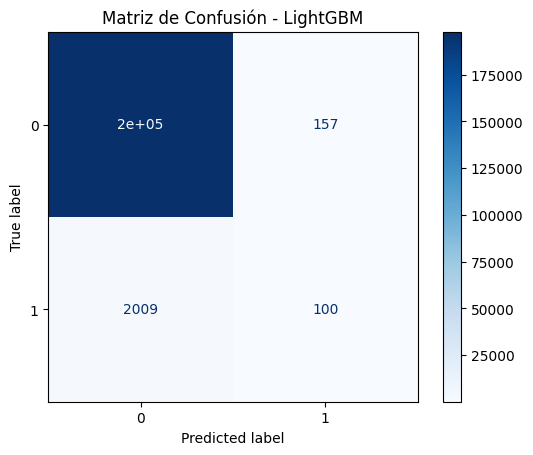

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Evaluacion del modelo
print(classification_report(y_test, y_pred, digits=4))

y_pred_best = best_model.predict(X_test)

# 3. Matriz de confusión
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title(f"Matriz de Confusión - {best_model_name}")
plt.show()

In [17]:
# Balanceando clases

X = data_encoded.drop(columns=['fraud_bool'])
y = data_encoded['fraud_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

neg, pos = y.value_counts()[0], y.value_counts()[1]
scale_pos_weight = neg / pos

models = {
    # 'Random Forest': RandomForestClassifier(
    #     n_estimators=100,
    #     class_weight='balanced',
    #     random_state=42
    # ),
    # 'XGBoost': xgb.XGBClassifier(
    #     eval_metric='logloss',
    #     scale_pos_weight=scale_pos_weight,
    #     random_state=42
    # ),
    'LightGBM': lgb.LGBMClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        max_depth = 20,
    )
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }
results

[LightGBM] [Info] Number of positive: 8920, number of negative: 791080
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3994
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011150 -> initscore=-4.485103
[LightGBM] [Info] Start training from score -4.485103


{'LightGBM': {'Accuracy': 0.82155,
  'Precision': 0.04493590264791175,
  'Recall': 0.7861545756282599,
  'F1 Score': 0.08501256216992258,
  'ROC AUC': 0.8837148446345853}}

              precision    recall  f1-score   support

           0     0.9972    0.8219    0.9011    197891
           1     0.0449    0.7862    0.0850      2109

    accuracy                         0.8216    200000
   macro avg     0.5211    0.8040    0.4931    200000
weighted avg     0.9872    0.8216    0.8925    200000



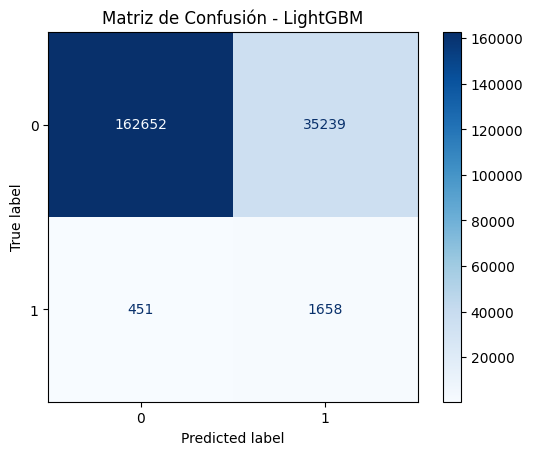

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Metricas
best_model_name = max(results, key = lambda k: results[k]['ROC AUC'])
best_model = models[best_model_name]
print(classification_report(y_test, y_pred, digits=4))

y_pred_best = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# 3. Matriz de confusión
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title(f"Matriz de Confusión - {best_model_name}")
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.82      0.90    197891
           1       0.04      0.79      0.09      2109

    accuracy                           0.82    200000
   macro avg       0.52      0.80      0.49    200000
weighted avg       0.99      0.82      0.89    200000



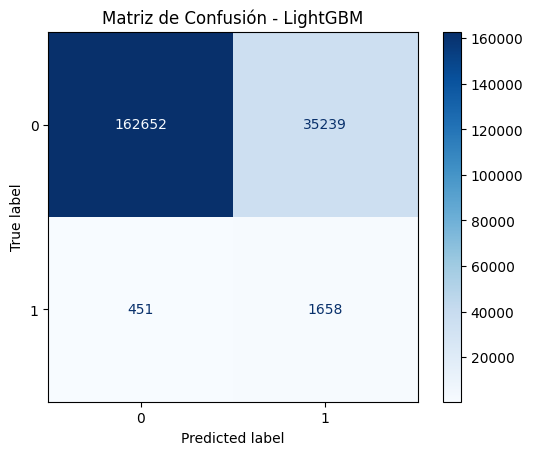

In [16]:
# para el primer grupo critico: lo mas relevante es en FP o FN
# en el grupo que se va a cancelar la matriz de confusion debe tener f1-score maximo posibnle
# es mas sencillos encontrar un punto minimo posible
# paso 1 encontrar umbral para personas que se deba cancelar (probar 2 treshhold a lavez  por cada treshold se aisla el grupo de segmento y obtener metricas de evaluacion)
# paso 2 encontrar umbral para personas que se deriba como observado

# grupo de datos test data set real
# grupo de datos val para deciones de modelamiento
# grupo de datos train

threshold = 0.5 # treshold para criticos
# threshold2 = 0.4 # treshold para observados

y_pred_new = (y_proba >= threshold).astype(int)
# y_pred_g1 = (y_proba >= threshold).astype(int)
# y_pred_g2 = (threshold >= y_proba >= threshold2).astype(int)
# y_pred_g3 = (threshold2 > y_proba).astype(int)

# Ahora evaluamos con la nueva predicción
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_new))

# 3. Matriz de confusión
cm = confusion_matrix(y_test, y_pred_new)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title(f"Matriz de Confusión - {best_model_name}")
plt.show()

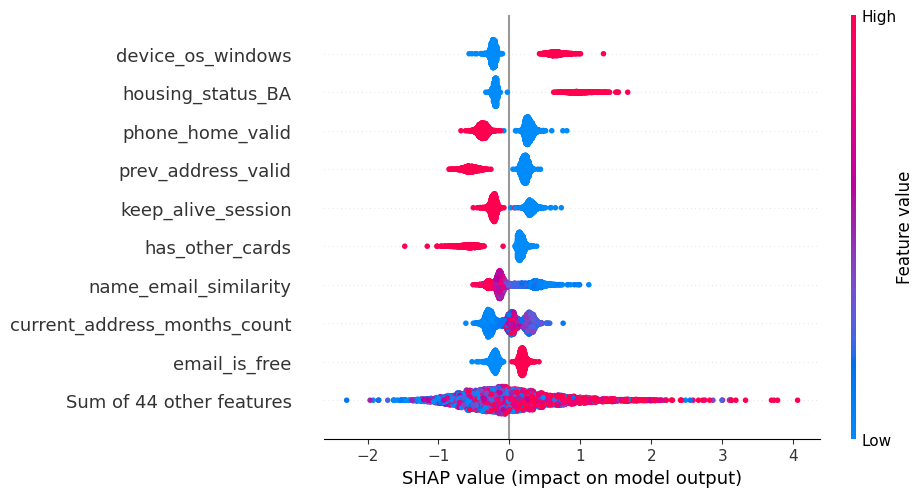

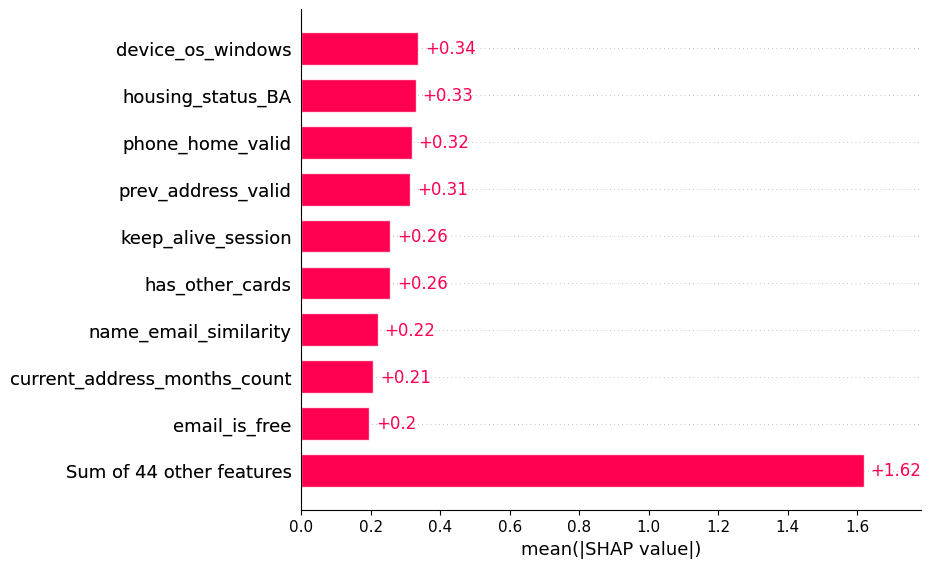

In [139]:
import shap
# Creador de explicaciones SHAP para modelos tree-based
explainer = shap.TreeExplainer(best_model)
sample = X_train.sample(min(5000, len(X_train)), random_state=42)
# Calculamos shap values para un subconjunto (para no explotar la RAM)
expl = explainer(sample) 
shap.plots.beeswarm(expl)
shap.plots.bar(expl)

In [87]:
pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imblearn]d-learn]
Note: you may need to restart the kernel to use updated packages.


In [90]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd


rus = RandomUnderSampler(random_state=42)


X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

print("Tamaño Train antes undersampling:", X_train.shape, 
      "Distribución:", y_train.value_counts())
print("Tamaño Train después undersampling:", X_train_res.shape, 
      "Distribución:", pd.Series(y_train_res).value_counts())

Tamaño Train antes undersampling: (800000, 50) Distribución: fraud_bool
0    791080
1      8920
Name: count, dtype: int64
Tamaño Train después undersampling: (17840, 50) Distribución: fraud_bool
0    8920
1    8920
Name: count, dtype: int64


In [98]:
data_encoded.columns[1:]

Index(['income', 'name_email_similarity', 'current_address_months_count',
       'customer_age', 'days_since_request', 'zip_count_4w', 'velocity_6h',
       'velocity_24h', 'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
       'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w', 'prev_address_valid',
       'log_bank_branch_count_8w', 'ratio_velocity_6h_24h',
       'ratio_velocity_24h_4w', 'payment_type_AA', 'payment_type_AB',
       'payment_type_AC', 'payment_type_AD', 'payment_type_AE',
       'employment_status_CA', 'employment_status_CB', 'employment_status_CC',
       'employment_status_CD', 'employment_status_CE', 'employment_status_CF',
       'employment_status_CG', 'housing_status_BA', 'housing_status_BB',
       'housing_status_BC'

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)


feat_importances = pd.Series(rf.feature_importances_, index=data_encoded.columns[1:]).sort_values(ascending=False)

print("\nTop 20 por random forest")
print(feat_importances.head(20))


perm_importance = permutation_importance(
    rf, X_test, y_test,
    n_repeats=5, random_state=42, n_jobs=-1
)

perm_feat_importances = pd.Series(
    perm_importance.importances_mean,
    index=all_feature_names
).sort_values(ascending=False)

print("\nTop 20 de importancia por permutacion")
print(perm_feat_importances.head(20))


Top 20 por random forest
housing_status_BA                   0.085842
current_address_months_count        0.061286
credit_risk_score                   0.056607
device_os_windows                   0.052588
name_email_similarity               0.052557
days_since_request                  0.037270
velocity_4w                         0.037020
session_length_in_minutes           0.036295
zip_count_4w                        0.035880
ratio_velocity_24h_4w               0.034379
velocity_24h                        0.034104
date_of_birth_distinct_emails_4w    0.034086
ratio_velocity_6h_24h               0.033999
velocity_6h                         0.033768
income                              0.030933
customer_age                        0.029398
bank_months_count                   0.028474
prev_address_valid                  0.026199
bank_branch_count_8w                0.025512
log_bank_branch_count_8w            0.025113
dtype: float64


NameError: name 'all_feature_names' is not defined

In [101]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from collections import Counter

print("Train balanceado:", Counter(y_train_res))
print("Test real:", Counter(y_test))


rf = RandomForestClassifier(
    n_estimators=20,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# gb = GradientBoostingClassifier(
#     n_estimators=20,
#     learning_rate=0.1,
#     max_depth=3,
#     random_state=42
# )

# knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# voting = VotingClassifier(
#     estimators=[("rf", rf), ("gb", gb), ("knn", knn)],
#     voting="soft",  
#     n_jobs=-1
# )

models = {
    "random Forest": rf,
    # "gradient Boosting": gb,
    # "KNN": knn,
    # "voting Ensemble": voting
}


for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\Modelo {name}")
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))

Train balanceado: Counter({0: 8920, 1: 8920})
Test real: Counter({0: 197891, 1: 2109})
\Modelo random Forest
              precision    recall  f1-score   support

           0     0.9969    0.8128    0.8955    197891
           1     0.0416    0.7629    0.0789      2109

    accuracy                         0.8123    200000
   macro avg     0.5193    0.7879    0.4872    200000
weighted avg     0.9868    0.8123    0.8869    200000

ROC-AUC: 0.8629399842582325


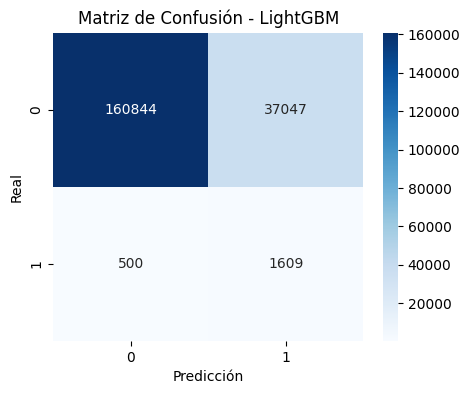

In [102]:
from sklearn.metrics import confusion_matrix

# Mostrar matriz de confusión del mejor modelo
y_pred_best = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de Confusión - LightGBM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()